# BERT base-uncased

> Suponha o par (3,2) (abacate, fruta) e os padrões (é um tipo de) e (é um)
> Temos as seguintes sentenças:
- [CLS] [MASK] ca te é um tipo de fru ta [SEP] aba ca te é um fru ta
- [CLS] aba [MASK] te é um tipo de fru ta [SEP] aba ca te é um fru ta
- [CLS] aba ca [MASK] é um tipo de fru ta [SEP] aba ca te é um fru ta
- [CLS] aba ca te é um tipo de [MASK] ta [SEP] aba ca te é um fru ta
- [CLS] aba ca te é um tipo de fru [MASK] [SEP] aba ca te é um fru ta
- [CLS] aba ca te é um tipo de fru ta [SEP] [MASK] ca te é um fru ta
- [CLS] aba ca te é um tipo de fru ta [SEP] aba [MASK] te é um fru ta
- [CLS] aba ca te é um tipo de fru ta [SEP] aba ca [MASK] é um fru ta
- [CLS] aba ca te é um tipo de fru ta [SEP] aba ca te é um [MASK] ta
- [CLS] aba ca te é um tipo de fru ta [SEP] aba ca te é um fru [MASK]

- Após isso os 10 scores são somados

- Usando quase todos datasets do artigo DIVE (faltou 1), eles foram pré-procesasdos. Retirou pares repetidos e pares com palavras compostas, também retirou a tag POS de cada palavra.

- DIVE e Word2vec foram testados novamente usando o json original do artigo no datasets (BLESS, EVALution, LenciBenotto, Weeds, wordnet).

- Nos datasets kotlerman2010.json, baroni2012.json, turney2014.json, levy2014.json foi utilizado o AP do artigo

- Os primeiros gráficos mostram o balanceamento de cada dataset.
  - % dos pares True para cada tamanho de subtoken

  - Quantidade total de pares para cada tamanho de subtoken

- último gŕafico mostra AP dos datasets.


> OBS: inconsistência nos datasets levy2014 e EVALution

> levy com pares duplicados (ele já estava assim, provavelmente no artigo tbm ficou assim)

In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nb_utils
import itertools

sns.set(style="whitegrid")
plt.clf()


path_json = "../../en-model/bert-base-uncased_bert_score_2020-10-30_20:38:00_comb"

dfs = {}
for filename in os.listdir(path_json):
    if os.path.isfile(os.path.join(path_json, filename)) and filename.endswith(".json"):
        df = nb_utils.create_dataframe(json.load(open(os.path.join(path_json, filename))), combination=True)
        dfs[filename] = df

path_json = "../../en-model/bert-base-uncased_bert_score_2020-11-02_19:14:53_comb_simples"
for filename in os.listdir(path_json):
    if os.path.isfile(os.path.join(path_json, filename)) and filename.endswith(".json"):
        df = nb_utils.create_dataframe(json.load(open(os.path.join(path_json, filename))), combination=True)
        dfs[filename] = df

tmp = dfs[filename]
pattern_unique_list = tmp['pattern'].unique().tolist()
len_total_unique = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

df_ratios = []
for dataset in dfs.keys():
    df_ratio = nb_utils.balanceamento(dfs[dataset], len_size=len_total_unique, patterns=pattern_unique_list)
    df_ratio['dataset'] = dataset
    df_ratios.append(df_ratio)

df_ratios = pd.concat(df_ratios)


for dataset_name, df in dfs.items():
    dfs[dataset_name] = nb_utils.logsumexp_normalization(df, len_list=len_total_unique, pattern_list=pattern_unique_list)

Balanceamento: 1 não está no dataframe!
Balanceamento: 8 não está no dataframe!
Balanceamento: 9 não está no dataframe!
Balanceamento: 10 não está no dataframe!
Balanceamento: 11 não está no dataframe!
Balanceamento: 12 não está no dataframe!
Balanceamento: 13 não está no dataframe!
Balanceamento: 14 não está no dataframe!
Balanceamento: 15 não está no dataframe!
Balanceamento: 16 não está no dataframe!
Balanceamento: 17 não está no dataframe!
Balanceamento: 18 não está no dataframe!
Balanceamento: 19 não está no dataframe!
Balanceamento: 20 não está no dataframe!
Balanceamento: 21 não está no dataframe!
Balanceamento: 22 não está no dataframe!
Balanceamento: 23 não está no dataframe!
Balanceamento: 24 não está no dataframe!
Balanceamento: 25 não está no dataframe!
Balanceamento: 26 não está no dataframe!
Balanceamento: 27 não está no dataframe!
Balanceamento: 28 não está no dataframe!
Balanceamento: 29 não está no dataframe!
Balanceamento: 30 não está no dataframe!
Balanceamento: 1 nã

<Figure size 432x288 with 0 Axes>

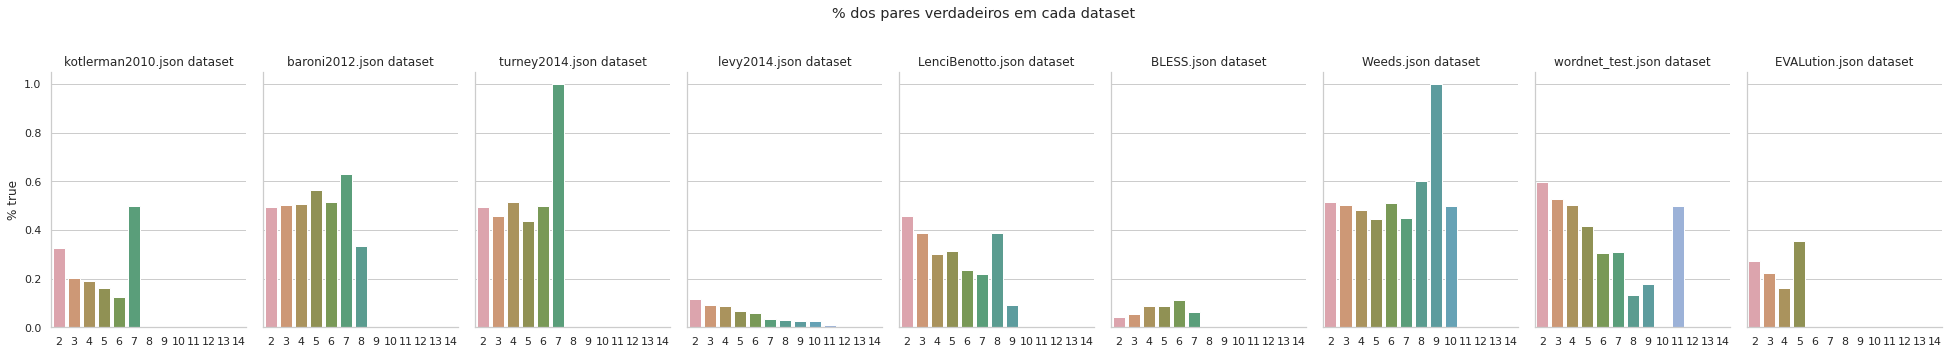

In [2]:
# % dos pares True por tamanho de subtoken
g = sns.catplot(x="len_total", y="ratio", col="dataset",
                data=df_ratios, saturation=.5,
                kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "% true")
#   .set_xticklabels(["Men", "Women", "Children"])
  .set_titles("{col_name} {col_var}")
  # .set(ylim=(0, 1))
  .despine(left=False))
plt.subplots_adjust(top=0.8)
_ = g.fig.suptitle('% dos pares verdadeiros em cada dataset')

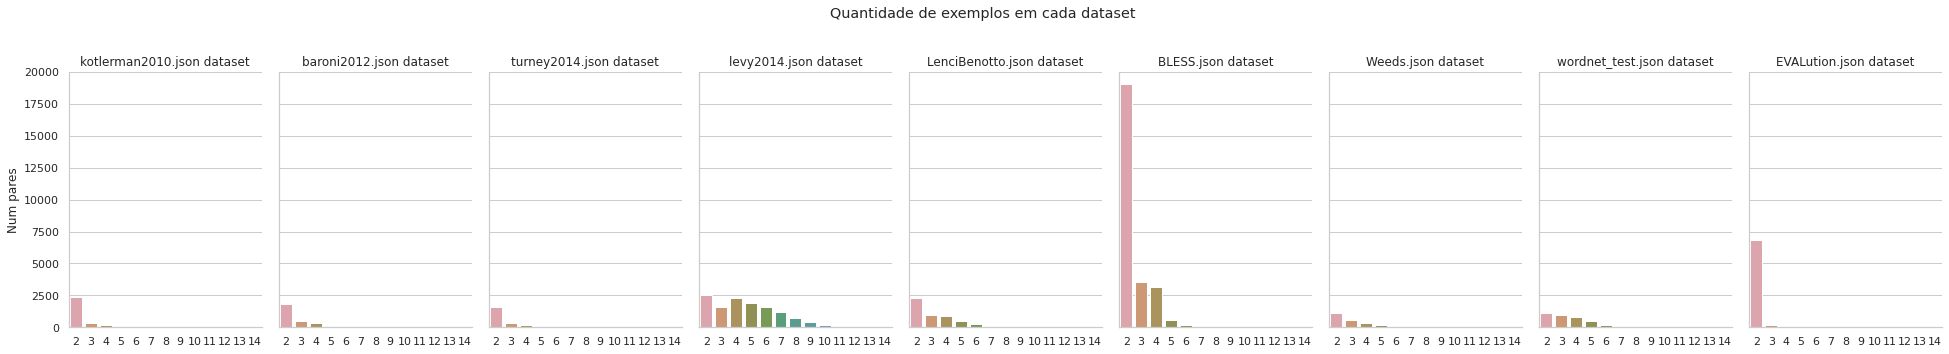

In [3]:
# Quantidade de pares por tamanho de subtoken
df_ratios['total'] = df_ratios['true'] + df_ratios['false']
g = sns.catplot(x="len_total", y="total", col="dataset",
                data=df_ratios, saturation=.5,
                kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Num pares")
#   .set_xticklabels(["Men", "Women", "Children"])
  .set_titles("{col_name} {col_var}")
  # .set(ylim=(0, 1))
  .despine(left=False))
plt.subplots_adjust(top=0.8)
_ = g.fig.suptitle('Quantidade de exemplos em cada dataset')


In [4]:
best_pattern_num = 4
best_pattern_train = ['{} or some other {}', '{} or any other {}', '{} and any other {}', '{} is a type of {}', '{} and some other {}', '{} which is kind of {}', '{} a special case of {}', '{} is a {}', '{} which is a example of {}', '{} and others {}', '{} which is called {}', '{} which is a class of {}', '{} or others {}', '{} , a {}', '{} including {}']
perm_pattern = list(map(list, itertools.permutations(best_pattern_train[:best_pattern_num], r=2)))
perm_pattern = list(map(lambda x: "_".join(x), perm_pattern))
# Melhores padrões para cada dataset
best_pattern_dataset = {}

for dataset_name, df in dfs.items():
    best_pattern_dataset[dataset_name] = nb_utils.compute_dataframe_AP_by_pattern(df, key_sort="score_final_log(z)", pattern_list=perm_pattern)

In [5]:
dset_dive = ['kotlerman2010.json', 'kotlerman2010.json', 'baroni2012.json', 'baroni2012.json',
             'turney2014.json','turney2014.json', 'levy2014.json', 'levy2014.json', 'BLESS.json', 'BLESS.json',
             'EVALution.json', 'EVALution.json', 'LenciBenotto.json', 'LenciBenotto.json', 'Weeds.json', 'Weeds.json',
             'wordnet_test.json', 'wordnet_test.json']
df_dive = pd.DataFrame({'dataset': dset_dive,
                        'method': ['word2vec', 'summation_dot_product'] * int(len(dset_dive)/2),
                        'AP': [0.395, 0.366, 0.718, 0.835, 0.521, 0.572, 0.112, 0.192, 0.0911, 0.1552, 0.2546, 0.3415,
                               0.4180, 0.5290, 0.5231, 0.6961, 0.6205, 0.6295]
                        })
df_en = []
method_score = ["score_final_log(z)", "bert_soma_total", "score_final_norm"]
for best_pattern_num in range(1, len(perm_pattern)+1):
    for dataset_name, df_data in dfs.items():
        # best_pattern = best_pattern_dataset[dataset_name]['padrao'].iloc[:best_pattern_num].tolist()
        best_pattern = perm_pattern[:best_pattern_num]
        for score_name in method_score[:1]:
            n_pair = df_data.groupby('pattern').count().iloc[0]['hiponimo']
            hyper_num = df_data[df_data['pattern'] == perm_pattern[0]]['fonte'].value_counts()
            hyper_num = hyper_num['hyper']
            min_ap, mean_ap = nb_utils.compute_AP_by_rank(df_data, key_sort=score_name, best_patterns=best_pattern)
            df = pd.DataFrame({'n_best': [best_pattern_num],'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': [f"min {score_name}"], 'AP': [min_ap]})
            df_en.append(df)
            df = pd.DataFrame({'n_best': [best_pattern_num],'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': [f"mean {score_name}"], 'AP': [mean_ap]})
            df_en.append(df)

df = pd.concat(df_en)

best_pattern_num = len(perm_pattern)
df = df[df['n_best'] == best_pattern_num]

df = pd.concat([df, df_dive])
df['method_format'] = df['method'].map(nb_utils.method_names)

print(f"Usando {best_pattern_num} combinações")

Usando 12 combinações


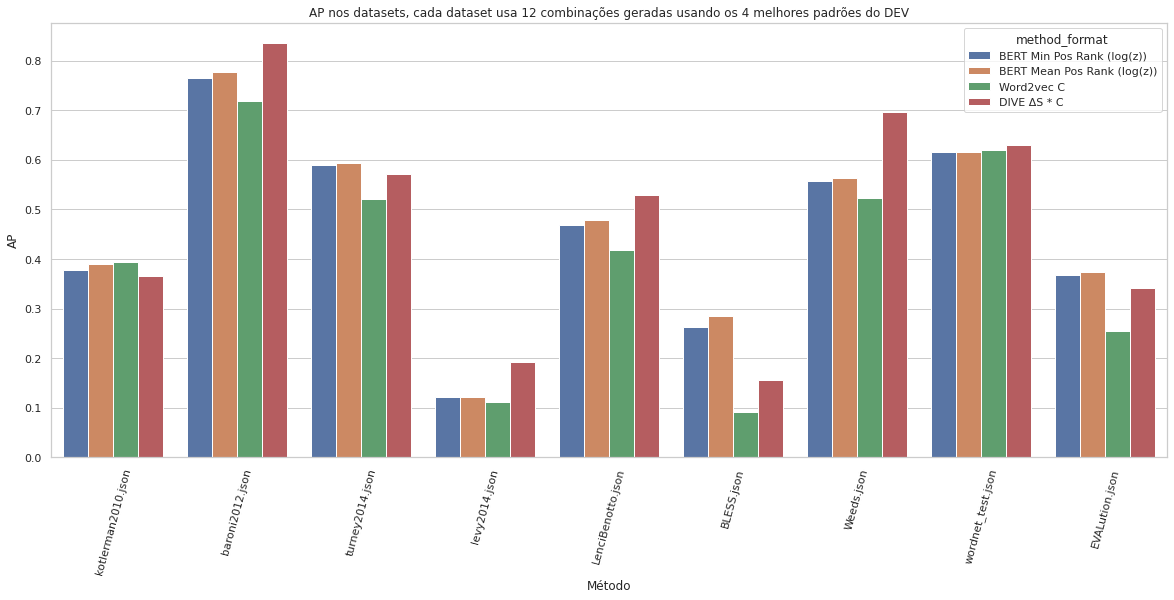

In [6]:
# AP por método
plt.figure(figsize=(20,8))
ax = sns.barplot(x='dataset' ,hue="method_format", y="AP", ci="sd",data=df)
ax.set(xlabel="Método")
ax.set_title(f"AP nos datasets, cada dataset usa {best_pattern_num} combinações geradas usando os 4 melhores"
             f" padrões do DEV")
_ = plt.xticks(rotation=75)

In [7]:
# print contagem
df_print = df_ratios.groupby('dataset').sum()[['true', 'false', 'total']]
df_print['ratio'] = df_print['true'] / df_print['total']
df_print

,true,false,total,ratio
dataset,,,,
BLESS.json,1337,25195,26532,0.050392
EVALution.json,1911,5196,7107,0.268890
LenciBenotto.json,1933,3077,5010,0.385828
Weeds.json,1119,1114,2233,0.501120
baroni2012.json,1385,1385,2770,0.500000
kotlerman2010.json,880,2060,2940,0.299320
levy2014.json,945,11657,12602,0.074988
turney2014.json,1058,1100,2158,0.490269
wordnet_test.json,1918,1893,3811,0.503280
